# Analyse en composantes principales

## Préliminaires

Nous allons avoir besoin pour le TP des bibliothèques suivantes (pas seulement pour l'algèbre):

In [1]:
import numpy as np
import numpy.random as ra
from scipy import linalg as lin
import matplotlib.pyplot as plt

### L'algèbre linéaire avec Numpy

Dans ce TP nous sommes amenés à effectuer de nombreux produits matriciels et scalaires. Voici quelques règles concernant Numpy:

* Le produit scalaire dans Numpy peut se faire via `np.dot(x,y)`, ou dans Python 3, via `x @ y`.
* Dans Numpy tous les vecteurs sont des vecteurs lignes, mais `y` dans les formules ci-dessus est interprété comme un vecteur colonne (avec comme conséquence que `@` n'est pas toujours associatif).
* De même, un opérateur matriciel `A` peut être appliqué à `y` via `np.dot(A,y)`, ou dans Python 3, via `A @ y`. Ici encore, `y` est interprété comme un vecteur colonne.
* Le produit matriciel `np.dot(A,B)`, ou dans Python 3, `A @ B`, suit les règles habituelles.
* Un tableau peut être transposé via l'attribut `.T`, par exemple `A.T`. 
* Il est possible de multiplier un vecteur ou une matrice par un scalaire en utilisant le signe de multiplication `*`  : `B = 3.0 * A`
* Le signe `*` sur deux matrices de même taille effectue une multiplication terme à terme.


# Analyse en composantes principales

Dans cette première étude nous allons réaliser une [analyse en composantes principales](https://www.astromatic.net/m2aais/notes/Decompositions.html#analyse-en-composantes-principales) (ACP) d'un jeu de spectres de sources (étoiles, galaxies, quasars). Ce travail nous permettra de nous familiariser avec
- le calcul des [vecteurs et de valeurs propres](https://fr.wikipedia.org/wiki/Valeur_propre,_vecteur_propre_et_espace_propre) d'un opérateur,
- le concept de [décorrélation](https://fr.wikipedia.org/wiki/D%C3%A9corr%C3%A9lation) de composantes,
- la [réduction dimensionnelle](https://fr.wikipedia.org/wiki/R%C3%A9duction_dimensionnelle).

## Les données

Le fichier `spec4000_recons_2023_interp.npz` est issu de la collection d'exemples [AstroML](https://www.astroml.org) et contient les [spectres](https://fr.wikipedia.org/wiki/Spectroscopie) de 4000 sources obtenus par le relevé [SDSS](https://www.sdss.org/).
Les spectres, en unités arbitraires de [densité de flux](https://fr.wikipedia.org/wiki/Densit%C3%A9_de_flux), couvrent le domaine de longueur d'onde allant de 3000 à 8000 Å et sont corrigés d'un [décalage vers le rouge](https://fr.wikipedia.org/wiki/D%C3%A9calage_vers_le_rouge) éventuel (ramenés dans le [référentiel](https://fr.wikipedia.org/wiki/R%C3%A9f%C3%A9rentiel_(physique)) de la source).
Pour chaque source certains intervalles spectraux ont dû être retouchés car inaccessibles en raison du décalage spectral ou contaminés par des raies atmosphériques.

Le chargement des données s'opère de la façon suivante:

In [2]:
spec = np.load("spec4000_recons_2023_interp.npz") 
print(spec.files)

['spectra', 'wave', 'masks', 'classes', 'labels', 'log_OIII_Hb', 'z', 'zerr', 'log_NII_Ha']


On constate que le fichier contient plusieurs [tableaux NumPy](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html). Pour ce TP nous n'allons charger que les spectres (tableau de vecteurs lignes), l'échelle des longueurs d'ondes (pour les tracés), le classement de chaque source, et les étiquettes associées.

In [3]:
spectra = spec["spectra"]
wave = spec["wave"]
classes = spec["classes"]
labels = spec["labels"]
masks = spec["masks"]

### 🏋 Exercice

Tout d'abord, nous allons manipuler un peu les données.
1. Vérifier le nombre de spectres disponibles et l'échantillonnage en fréquence de chacun d'entre eux.
2. Combien de classes de spectres différents trouve-t-on dans cet ensemble (indication : on peut utiliser l'opérateur `set` pour transformer une liste en un ensemble d'éléments uniques)? Quels sont les noms de ces classes ?


In [4]:
#1
print(f'Nb spectres : {len(spectra)}')
print(f'Echelle de lambda - Min : {wave[0]}, Max : {wave[-1]}, N : {len(wave)}') #C'est en angstrom ?

#2
sets = set(classes)
print(f'Nb of classes : {len(sets)}')
print(f'Classes : {sets}')



Nb spectres : 4000
Echelle de lambda - Min : 3162.2776601683795, Max : 7935.969681957695, N : 1000
Nb of classes : 5
Classes : {0, 1, 2, 3, 4}


3. On peut afficher le nombre de spectres de chaque classe par ordre croissant grâce aux instructions suivantes. Assurez-vous de bien comprendre, complètement, ces instructions, et commentez le mieux possible chaque ligne.

In [5]:
classeU = np.array(list(set(classes))) # Set des classes converti en tableau np (liste desordonnée d'éléments uniques) 
nclasse = np.array([np.sum(classes==cl) for cl in classeU]) # Création de la liste du nombre d'éléments par classe 
classeU = classeU[np.argsort(nclasse)] # Tri du set des classes relativement à leur nombre de spectres 
nclasse = np.sort(nclasse) # Idem pour la liste du nombre de spectres par classe 
for i in range(len(classeU)):
    print(labels[classeU[i]],":",nclasse[i],"objets")

unknown : 1 objets
late star : 10 objets
star : 19 objets
QSO : 20 objets
galaxy : 3950 objets



4. Pour chaque classe afficher 3 spectres (on utilisera pour les abscisses l'échelle commune des longueurs d'onde du tableau `wave`). Discutez des propriétés qualitatives. Peut-on les distinguer à l'oeil ?
5. Filtrer la base de spectres (i.e. les variables `spectra`, `classes`, `classeU` et `nclasse`) pour en retirer les spectres sans label ("unknown").

{0, 1, 2, 3, 4}
5


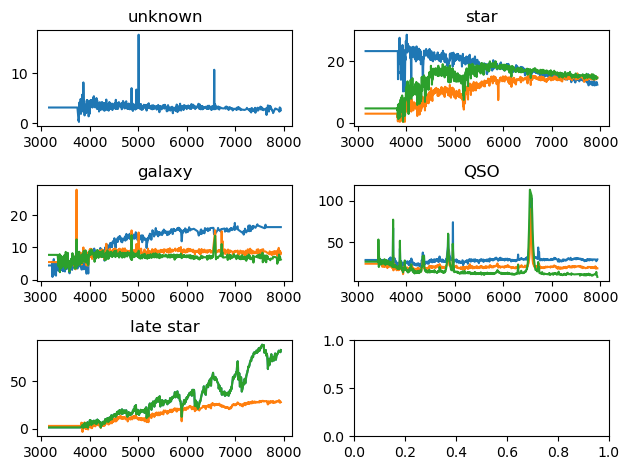

In [6]:
#4 
numerosSpectraByClass = [[] for k in set(classes)]
print(set(classes))
print(len(numerosSpectraByClass))
for k in range(len(classes)):
    numerosSpectraByClass[classes[k]].append(k)
fig,ax = plt.subplots(len(set(classes))//2+1,2)
for n in set(classes):
    toDraw = np.random.randint(low = 0,high = len(numerosSpectraByClass[n]),size = min(len(numerosSpectraByClass[n]),3))
    ax[n//2,n%2].title.set_text(labels[n])    
    for i in toDraw:
        ax[n//2,n%2].plot(wave,spectra[numerosSpectraByClass[n][i]])
fig.tight_layout()
# Distinguer à l'oeil ne semble pas évident mais possible

#5

for i in range(len(classes)):
    if labels[classes[i]]=='unknown':
        cleanedclasses = np.delete(classes,i,0)
        cleanedspectra = np.delete(spectra,i,0)
for i in range(len(classeU)):
    if labels[classeU[i]] == 'unknown':
        cleanedclasseU = np.delete(classeU,i,0)
        cleanednclasse = np.delete(nclasse,i,0)
classes,spectra,classeU,nclasse = cleanedclasses,cleanedspectra,cleanedclasseU,cleanednclasse






On se débarrasse pour la suite de la classe `unknown`:

In [7]:

if labels[classeU[0]] == 'unknown': # vérifie qu'on n'a pas déjà fait cette sélection
    print('On fait une sélection pour exclure les classifications inconnues')
    spectra = spectra[classes!=0]
    classes = classes[classes!=0]
    classeU = classeU[1:]
    nclasse = nclasse[1:]
else:
    print('Sélection déjà faite...')

Sélection déjà faite...


## Axes principaux

### 🏋 Exercice
1. Normaliser l'amplitude de chaque spectre de sorte que la moyenne de chaque spectre vaille 1. Quel est l'intérêt d'une telle normalisation pour l'analyse en composante principales?
2. Calculer la matrice de covariance empirique corrigée associée au jeu de spectres normalisés, dans l'espace des signaux (matrice 1000×1000 attendue, c'est bien la covariance pour chaque échantillon de longueur d'onde que l'on cherche).
3. Calculer le spectre normalisé moyen et l'afficher. Le comparer à des spectres (normalisés) des différentes familles.

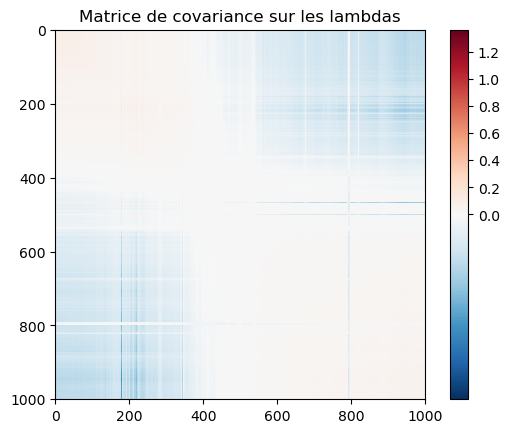

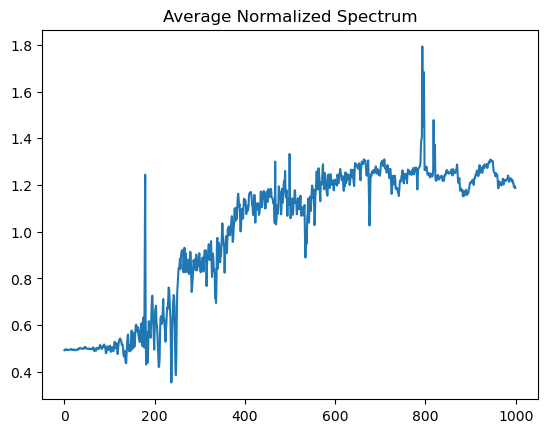

{1, 2, 3, 4}
5


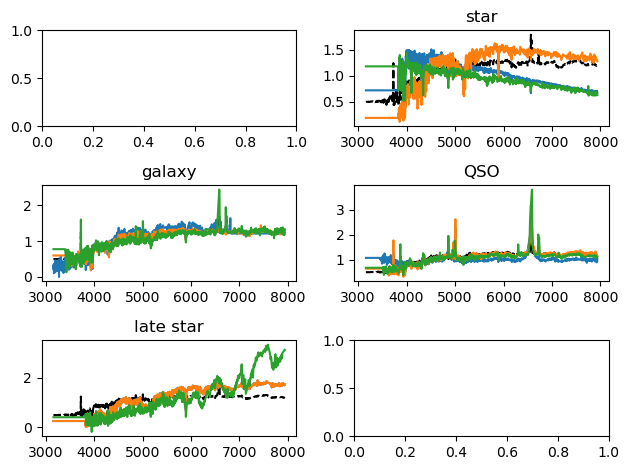

In [8]:
#1
# On ne veut pas discriminer les signaux sur leur temps d'exposition / leur magnitude ... qui n'apportent rien à la détermination de la catégorie d'objets.
for k in range(len(spectra)):
    avg = np.average(spectra[k])
    spectra[k]/=avg


#2
covMat = np.cov(spectra.T)
plt.imshow(covMat)
from matplotlib.colors import TwoSlopeNorm

norm = TwoSlopeNorm(vmin=covMat.min(), vcenter=0, vmax=covMat.max())
pc = plt.pcolormesh(covMat, norm=norm, cmap="RdBu_r")
plt.colorbar(pc)
plt.title(f'Matrice de covariance sur les lambdas')
plt.show()

#3
averageSpectrum = [np.average(spectra[:,k]) for k in range(len(wave))]
plt.plot(averageSpectrum)
plt.title("Average Normalized Spectrum")
plt.show()

numerosSpectraByClass = [[] for k in range(len(set(classes))+1)] # +1 pour l'objet unknown
print(set(classes))
print(len(numerosSpectraByClass))
for k in range(len(classes)):
    numerosSpectraByClass[classes[k]].append(k)
fig,ax = plt.subplots(len(set(classes))//2+1,2)
for n in set(classes):
    toDraw = np.random.randint(low = 0,high = len(numerosSpectraByClass[n]),size = min(len(numerosSpectraByClass[n]),3))
    ax[n//2,n%2].title.set_text(labels[n])
    ax[n//2,n%2].plot(wave,averageSpectrum,linestyle = '--',color = 'black')
    for i in toDraw:
        ax[n//2,n%2].plot(wave,spectra[numerosSpectraByClass[n][i]])
fig.tight_layout()
plt.show()
  


4. Extraire le spectre des valeurs propres et la matrice des vecteurs propres de la matrice de covariance (on pourra utiliser la fonction [`np.linalg.eigh()`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eigh.html)).
5. Réorganiser le spectre des valeurs propres et la matrice des vecteurs propres par valeurs propres décroissantes (on pourra utiliser la fonction [`np.argsort()`](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html)).

In [9]:
#4

eigenValues,eigenVectors = np.linalg.eigh(covMat)

#5
eigenVectors = eigenVectors[:,np.argsort(-eigenValues)]
eigenValues = eigenValues[np.argsort(-eigenValues)] # Le - car on veut les plus grandes vp en premier 



## Exploration de la décomposition

### 🏋 Exercice
1. Afficher le spectre de la décomposition, c'est à dire les valeurs propres par valeurs décroissantes. Commenter.

In [10]:
# 1
print(eigenValues)

[2.60112863e+01 3.62834244e+00 1.59435483e+00 7.66841644e-01
 5.10135657e-01 4.69003300e-01 3.66038294e-01 1.83450375e-01
 1.60341248e-01 1.30739858e-01 1.07669461e-01 9.60145963e-02
 8.96073556e-02 6.82950380e-02 5.70199063e-02 5.39272833e-02
 4.79418801e-02 4.46498009e-02 4.37859787e-02 3.73439850e-02
 3.56727092e-02 3.49261813e-02 3.24049284e-02 2.97378861e-02
 2.89483840e-02 2.79406559e-02 2.69087975e-02 2.59078558e-02
 2.56086136e-02 2.48049355e-02 2.42606482e-02 2.21896889e-02
 2.18021729e-02 2.10602895e-02 2.03850286e-02 2.02079169e-02
 1.99121100e-02 1.96423837e-02 1.91149115e-02 1.86872273e-02
 1.85849469e-02 1.82176708e-02 1.80842965e-02 1.76189526e-02
 1.75110138e-02 1.73785534e-02 1.72771757e-02 1.71004209e-02
 1.68972328e-02 1.65633070e-02 1.64302814e-02 1.62293019e-02
 1.60708954e-02 1.60597047e-02 1.57977760e-02 1.55190261e-02
 1.54955677e-02 1.53369671e-02 1.52381548e-02 1.51664613e-02
 1.48719172e-02 1.47970150e-02 1.46376701e-02 1.45939866e-02
 1.44216179e-02 1.435145

2. Afficher quelques vecteurs propres (axes principaux) parmi les premiers et les derniers. Commenter. Quelle est leur moyenne ?

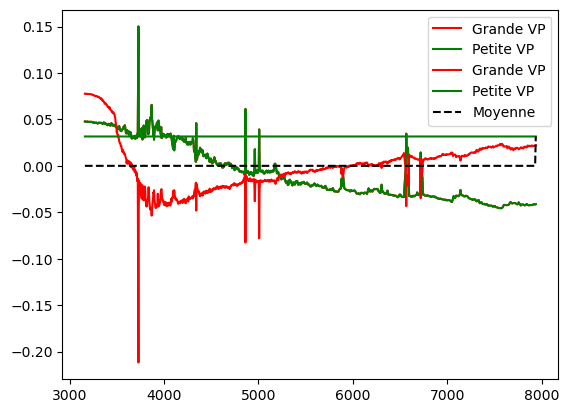

In [11]:

#2
i = 2
for k in range(i):
    plt.plot(wave,eigenVectors[:,k],color = 'red',label='Grande VP')
    plt.plot(wave,eigenVectors[:,-k],color = 'green',label='Petite VP')
averageEVector = [np.average(eigenVectors[:,k]) for k in range(len(eigenVectors))]
plt.plot(wave,averageEVector,linestyle = '--',color = 'black', label='Moyenne')
plt.legend()
plt.show()



3. Vérifier que comme attendu les vecteurs propres sont orthogonaux deux à deux

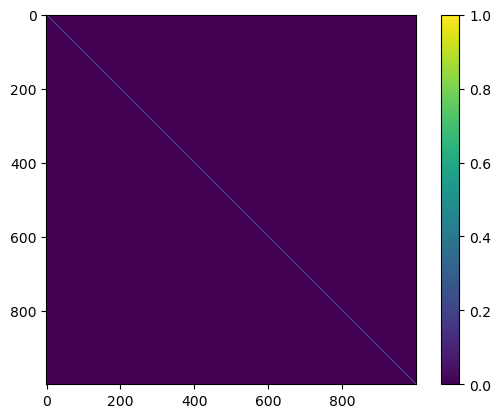

In [12]:

#3
pdtScalaires = [[np.dot(eigenVectors[:,i],eigenVectors[:,j]) for j in range(len(eigenVectors))] for i in range(len(eigenVectors))]
plt.imshow(pdtScalaires)
plt.colorbar()
plt.show()

4. Tracer fraction de variance totale expliquée $r(k)$ (somme des valeurs propres $\lambda_i$ avec $i\le k$) en fonction du nombre de composantes principales considéréees $k$ (avec $1 \le k \le 1000$) ? Que laisse augurer le comportement de $r$ en matière de réduction dimensionnelle? Quelle est la contribution des 5 premiers vecteurs propres, des 100 derniers ? Combien doit-on en conserver pour représenter 90%, 95% de l'information ? 

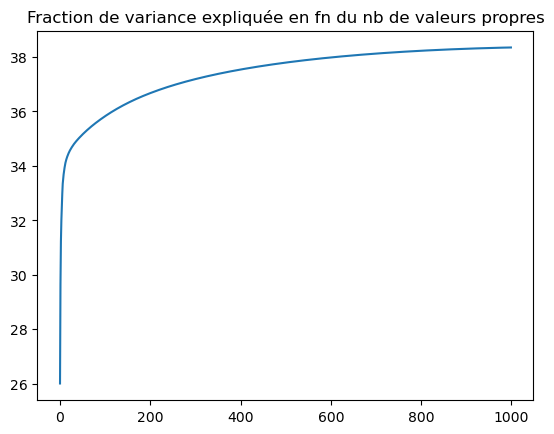

Contribution des 5 premiers termes : 32.97996419057267
Contribution des 100 derniers termes : 0.04735156525028117


In [13]:
# 4
r = 0
rlist = []
for l in eigenValues:
    r += l
    rlist.append(r)
plt.plot(rlist)
plt.title('Fraction de variance expliquée en fn du nb de valeurs propres')
plt.show()
print(f'Contribution des 5 premiers termes : {rlist[5]}')
print(f'Contribution des 100 derniers termes : {rlist[-1]-rlist[-101]}')
# Question : 90% de l'info = 90% de la covariance ou racine ?

## Projections sur les axes

### 🏋 Exercice

1. Calculer par projection sur les vecteurs propres les 2 premières composantes principales pour chacun des 4000 spectres. Montrer qu'elles sont décorrélées (on n'oubliera pas de soustraire le spectre moyen avant de réaliser les produits scalaires).


[-4.80986825e+00  2.88916867e-01  1.16588255e-01 -1.24175332e-02
 -5.10352262e-01 -8.76657317e-02  3.04043445e-01  3.08409689e-01
  8.86126583e-02 -1.66561970e-01  4.09248511e-01  9.17641705e-02
  1.84840072e-01 -2.35028073e-01  1.94210398e-01 -2.47171787e-01
  2.09719316e-01 -2.42774703e-02  1.54163526e-01 -2.65095538e-01
 -1.66537471e-02 -2.43572353e-01  5.10815420e-02  2.92433886e-01
 -1.19395338e-01 -2.70491210e-02 -1.72318173e-01  7.42125084e-02
  5.47124555e-02 -7.59010251e-03  4.85792339e-02 -8.13711573e-02
  3.21660970e-02  8.13460310e-02 -1.04571281e-01 -2.16530591e-02
  6.95713124e-02  9.68020870e-02 -2.86608909e-03  4.68842721e-03
 -6.94207751e-02  5.21283201e-02  3.16112116e-02 -1.17302905e-01
 -1.17755107e-01  5.27661553e-02 -4.48628249e-02  1.51885134e-01
  5.88525177e-03 -7.63353420e-02 -4.05177881e-02 -5.06323202e-02
 -3.04582590e-02  2.80055008e-02  6.84268008e-02  6.68686171e-04
 -2.08763356e-01  8.04443923e-02  1.16785721e-01  4.16280247e-02
 -2.77703254e-02  1.03251

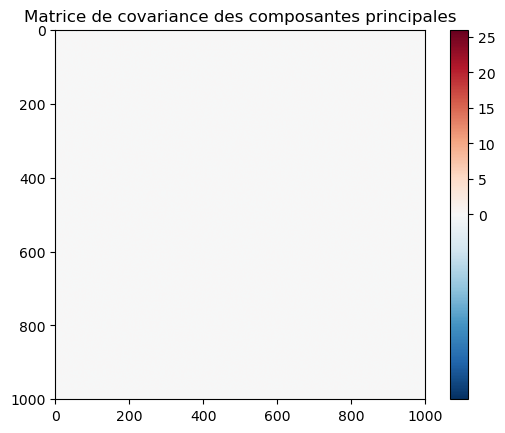

In [14]:
#1
for k in range(len(spectra)):
    spectra[k] -= averageSpectrum
#print(np.shape(spectra))
PCAspectra = np.dot(spectra,eigenVectors)
print(PCAspectra[1])
print(np.shape(PCAspectra))

covPCA = np.cov(PCAspectra.T)
plt.imshow(covPCA)
print(covPCA.min(),covPCA.max())
norm = TwoSlopeNorm(vmin=covPCA.min(), vcenter=0, vmax=covPCA.max())
pc = plt.pcolormesh(covPCA, norm=norm, cmap="RdBu_r")
plt.colorbar(pc)
plt.title(f'Matrice de covariance des composantes principales')
plt.show()

2. Calculer en une opération python la projection pour toutes les composantes principales. Vérifier la décorrélation.


In [15]:

#2

#Directement fait en #1


## Réduction dimensionnelle et reconstruction partielle

On a vu que seuls quelques composantes dominaient le spectre et la cumulative de la matrice de covariance. Ce sont les composantes les plus informatives. On a tracé les vecteurs correspondants qui visuellement contiennent de l'information sur les spectres contrairement aux moins informatifs qui se comportaient comme du bruit (d'amplitude variable cependant). 
On peut utiliser ces propriétés pour produire des reconstructions partielles des spectres filtrées des composantes les moins informatives.

### 🏋 Exercice
1. Reconstruire partiellement tous les spectres normalisés à partir du spectre moyen et du premier vecteur propre. Reproduire les figures de la première partie et afficher pour un exemple de chaque classe le spectre, la moyenne des spectres, la reconstruction partielle et la différence avec le spectre. Commenter.


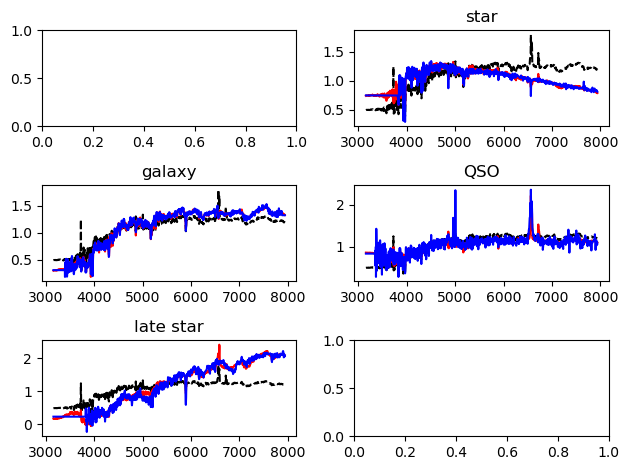

In [16]:

#1
seuil = 0.85
composantesAInclure = [int(rlist[k]/rlist[-1]<seuil) for k in range(len(eigenValues))]
composantesAInclure = np.diag(composantesAInclure)

partialPCA = np.dot(PCAspectra,composantesAInclure)


reconstructedSpectra = np.dot(partialPCA,eigenVectors.T)
for k in range(len(spectra)):
    spectra[k] += averageSpectrum
    reconstructedSpectra[k] += averageSpectrum


numerosSpectraByClass = [[] for k in range(len(set(classes))+1)] # +1 pour l'objet unknown
for k in range(len(classes)):
    numerosSpectraByClass[classes[k]].append(k)

fig,ax = plt.subplots(len(set(classes))//2+1,2)
nbToDraw = 1
for n in set(classes):
    toDraw = np.random.randint(low = 0,high = len(numerosSpectraByClass[n]),size = min(len(numerosSpectraByClass[n]),nbToDraw))
    ax[n//2,n%2].title.set_text(labels[n])
    ax[n//2,n%2].plot(wave,averageSpectrum,linestyle = '--',color = 'black')
    for i in toDraw:
        ax[n//2,n%2].plot(wave,reconstructedSpectra[numerosSpectraByClass[n][i]],color = 'red')
        ax[n//2,n%2].plot(wave,spectra[numerosSpectraByClass[n][i]],color = 'blue')
fig.tight_layout()

plt.show()



2. Reprendre la question avec le nombre de composante calculées au dessus pour 85% de l'information et pour 95%. On essaiera de tirer parti au maximum du calcul matriciel pour s'affranchir des boucles.Commenter.


(on essaiera de tirer parti au maximum du calcul matriciel pour s'affranchir des boucles).
3. Tracer les reconstructions des trois exemples choisis en 1 et les comparer au spectres initiaux normalisés (on pourra aussi tracer la différence pour illustrer la qualité de reconstruction).

In [17]:
# 2
# Fait (ou presque) en #1


## Séparation
On a vu que selon les types d'objets, il fallait plus ou moins de composante pour les représenter efficacement.
Nous allons maintenant explorer cela sommairement en montrant le comportement joint des composantes. Dans les cas les plus simples ce genre d'exploration suffit à séparer des populations d'objets différents. Ce n'est que partiellemenent le cas ici. 

### 🏋 Exercice
1. Afficher dans un même diagramme chaque spectre comme un point d'abcisse égale à la première composante et d'ordonnée égale à la seconde composante, en choissant des couleurs par classe d'objet. On prendra soin d'afficher d'abord la classe contenant le plus d'objets afin de rendre la figure lisible ! Commenter.

2. Construire avec `plt.subplots` un triangle de ces comportements joints pour les 6 premières composantes prises 2 à 2. Commenter.




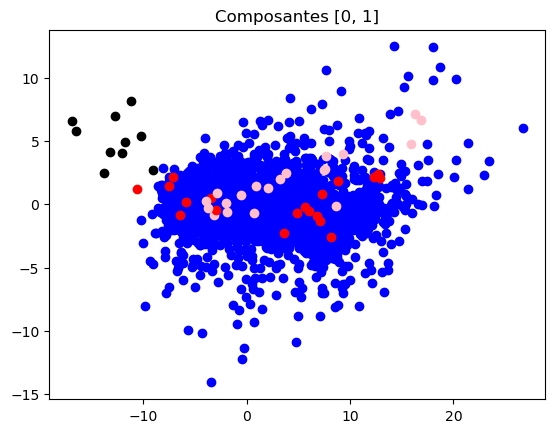

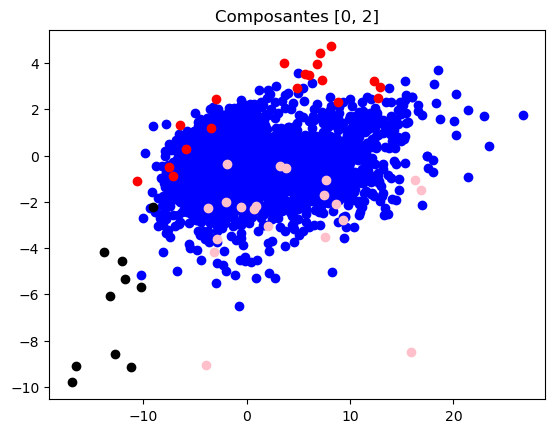

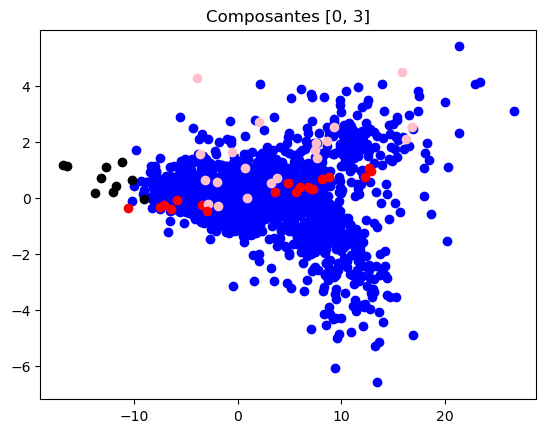

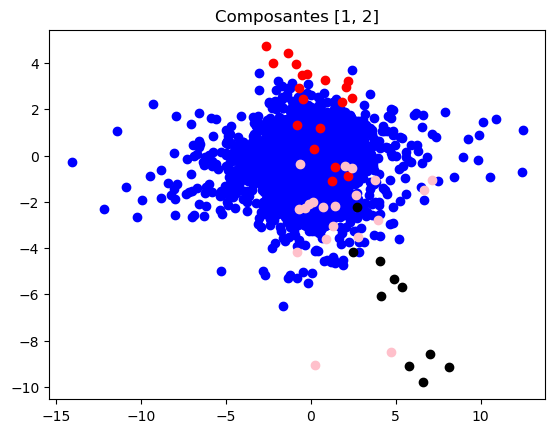

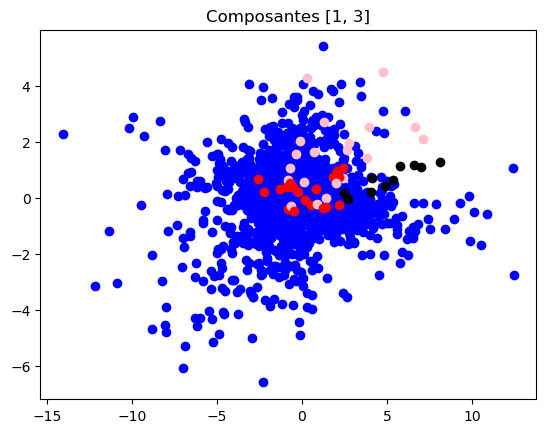

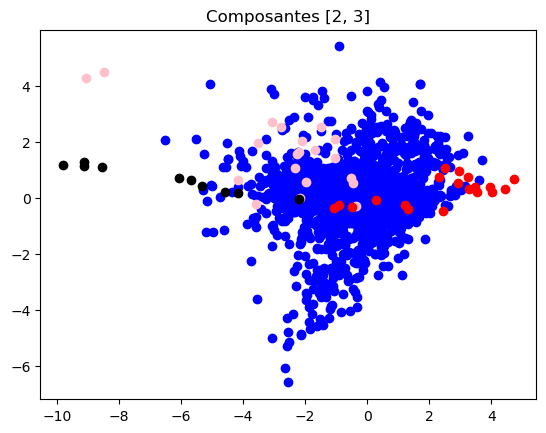

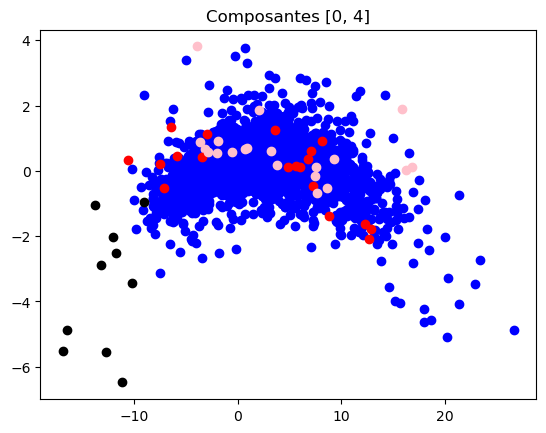

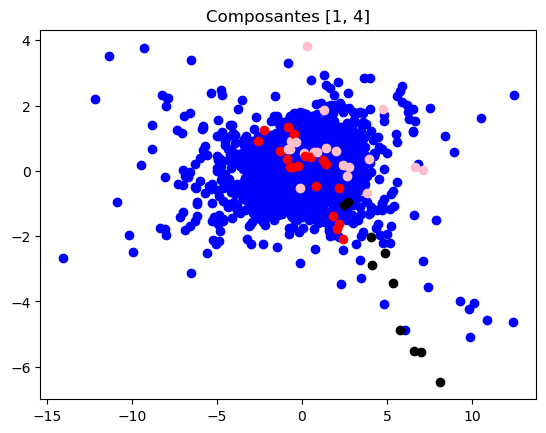

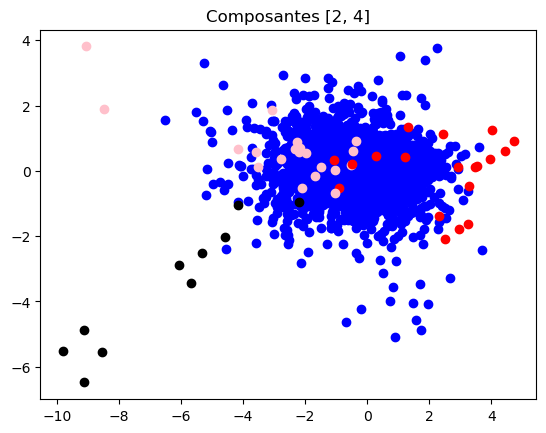

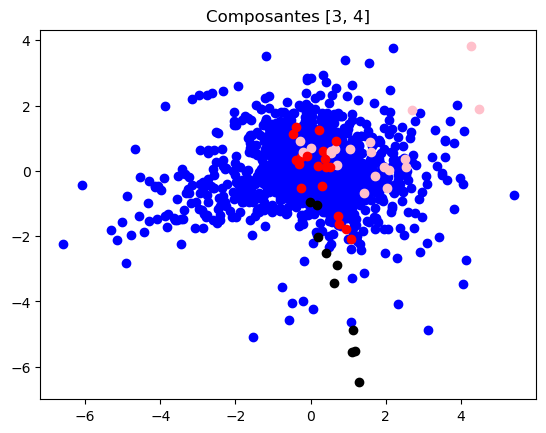

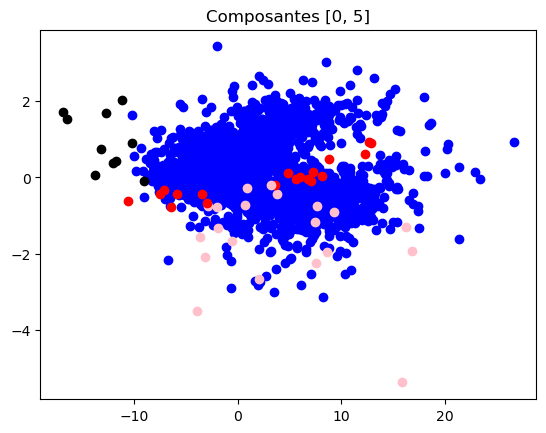

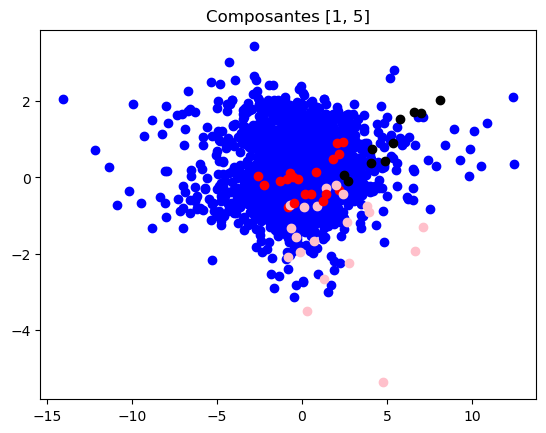

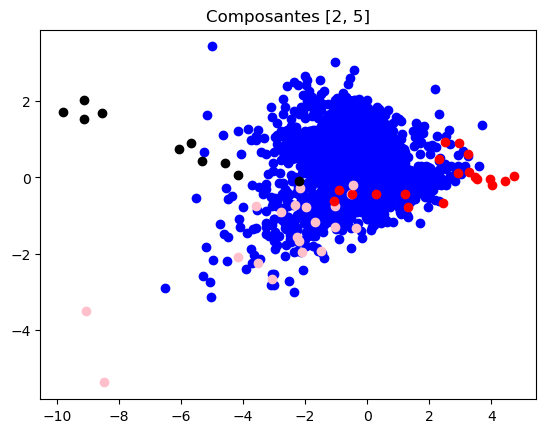

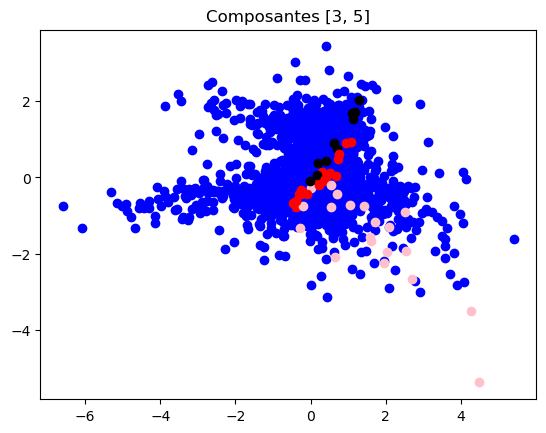

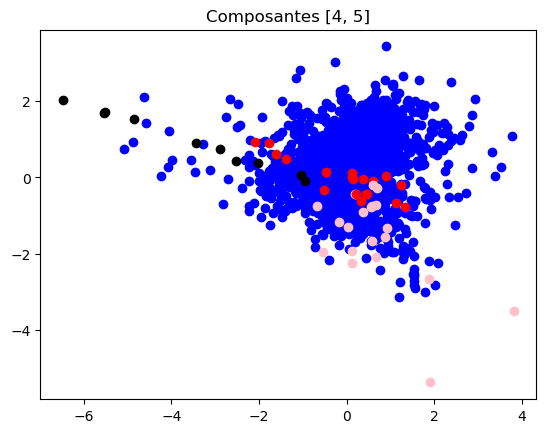

In [19]:
#1
couleurs = {
    0 : 'g',
    1 : 'r',
    2 : 'b',
    3 : 'pink',
    4 : 'black'
}
indexes = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3],[0,4],[1,4],[2,4],[3,4],[0,5],[1,5],[2,5],[3,5],[4,5]]
for i in indexes :
        
    for k in range(len(PCAspectra)):
        if classes[k]==2:
            plt.scatter(PCAspectra[k][i[0]],PCAspectra[k][i[1]],color = couleurs[classes[k]])
    for k in range(len(PCAspectra)):
        if classes[k]!=2:
            plt.scatter(PCAspectra[k][i[0]],PCAspectra[k][i[1]],color = couleurs[classes[k]])

    plt.title(f'Composantes {i}')

    plt.show()




#2